In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
import itertools
import dask
import dask.dataframe as dd 

sys.path.append('/projects/dedu0223/spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow


In [22]:
def add_s1_depths(row):
    c = row.C
    
    ds = calc_snow_index_to_snow_depth(dsB, C=c, inplace=False)
    rmse_wet, rmse = get_bias(ds, closest_ts)
    return rmse_wet, rmse

def get_bias(ds, closest_ts):
    mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                        ds['wet_snow'].sel(time=closest_ts).astype(bool))
    bias_wet = (ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)).mean()
    
                # Compare snow depths - no wet snow mask
    mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
    bias = (ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)).mean()
    
    return bias_wet.values, bias.values

def change_b(ds, b):
    ds = calc_delta_gamma(ds, B=b, inplace=False)
    ds = clip_delta_gamma_outlier(ds)
    ds = calc_snow_index(ds)
    ds = id_newly_wet_snow(ds)
    ds = id_wet_negative_si(ds)
    ds = id_newly_frozen_snow(ds)
    ds = flag_wet_snow(ds)
    return ds

In [31]:
A = [1]
B = [1]
C = np.arange(0, 2, 0.05)

all_biases = pd.DataFrame({'C':C})

In [36]:
# %%time
files = sorted(glob('/projects/dedu0223/snow_ex_data/*.nc'))

for f in files:#:[8:]:
    ds_name = f.split('stacks/')[-1].split('.')[0].split('/')[-1]
    
    if ds_name not in ['Banner_2021-03-15']:
        print(datetime.now(), f' -- starting {ds_name}')
        ds_ = xr.open_dataset(f).load() # Open dataset 


        dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]

        td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
        closest_ts_idx = np.where(td == td.min())[0][0]
        closest_ts = dataset.time[closest_ts_idx]

        for a in A:
            dsA = calc_delta_cross_ratio(dataset, A=a, inplace=False)
            for b in B:
                dsB = change_b(dsA, b)
                dfC = pd.DataFrame({'C':C})

                ddf = dd.from_pandas(dfC, npartitions=8)
                output_series = ddf.apply(add_s1_depths, axis=1, result_type='expand', meta=({0: float, 1: float}))
                output_series = output_series.compute()

                all_biases[f'{ds_name}_wet'] = output_series[0]
                all_biases[f'{ds_name}'] = output_series[1]

2023-04-19 15:41:45.330452  -- starting Banner_2020-02-18
2023-04-19 15:41:49.566362  -- starting Banner_2021-03-15
2023-04-19 15:41:49.566430  -- starting Cameron_2021-03-19
2023-04-19 15:41:54.216848  -- starting Dry_Creek_2020-02-19
2023-04-19 15:42:01.297062  -- starting Frasier_2020-02-11
2023-04-19 15:42:06.316355  -- starting Frasier_2021-03-19
2023-04-19 15:42:11.716039  -- starting Little_Cottonwood_2021-03-18
2023-04-19 15:42:17.924930  -- starting Mores_2020-02-09
2023-04-19 15:42:22.176454  -- starting Mores_2021-03-15


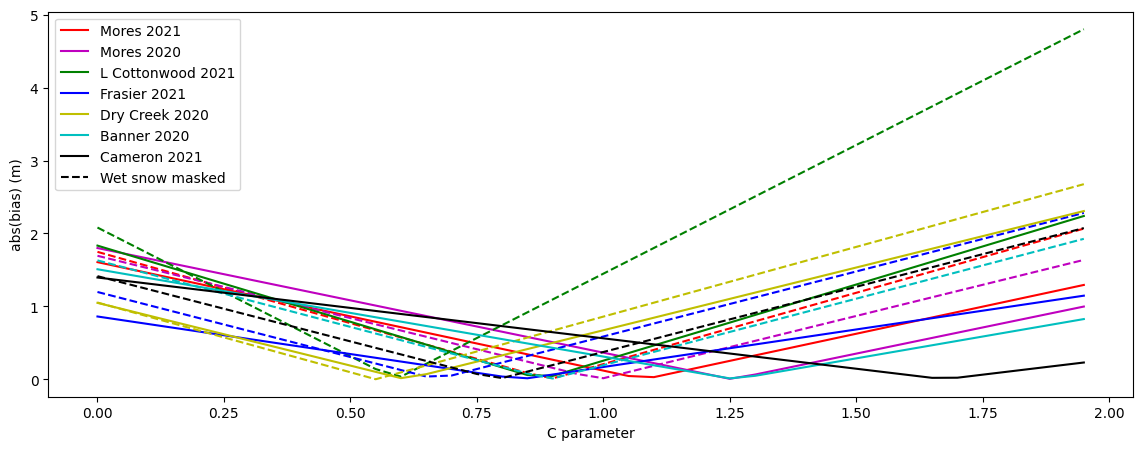

In [55]:
plt.figure(figsize = (14,5))

plt.plot(all_biases.C, np.abs(all_biases['Mores_2021-03-15']),'r', label = 'Mores 2021')
plt.plot(all_biases.C, np.abs(all_biases['Mores_2021-03-15_wet']),'r--')

plt.plot(all_biases.C, np.abs(all_biases['Mores_2020-02-09']),'m', label = 'Mores 2020')
plt.plot(all_biases.C, np.abs(all_biases['Mores_2020-02-09_wet']),'m--')

plt.plot(all_biases.C, np.abs(all_biases['Little_Cottonwood_2021-03-18']),'g', label = 'L Cottonwood 2021')
plt.plot(all_biases.C, np.abs(all_biases['Little_Cottonwood_2021-03-18_wet']),'g--')

plt.plot(all_biases.C, np.abs(all_biases['Frasier_2021-03-19']),'b', label = 'Frasier 2021')
plt.plot(all_biases.C, np.abs(all_biases['Frasier_2021-03-19_wet']),'b--')

plt.plot(all_biases.C, np.abs(all_biases['Dry_Creek_2020-02-19']),'y', label = 'Dry Creek 2020')
plt.plot(all_biases.C, np.abs(all_biases['Dry_Creek_2020-02-19_wet']),'y--')

plt.plot(all_biases.C, np.abs(all_biases['Banner_2020-02-18']),'c', label = 'Banner 2020')
plt.plot(all_biases.C, np.abs(all_biases['Banner_2020-02-18_wet']),'c--')

plt.plot(all_biases.C, np.abs(all_biases['Cameron_2021-03-19']),'k', label = 'Cameron 2021')
plt.plot(all_biases.C, np.abs(all_biases['Cameron_2021-03-19_wet']),'k--', label = 'Wet snow masked')

plt.legend()
plt.xlabel('C parameter')
plt.ylabel('abs(bias) (m)')

plt.savefig('/projects/dedu0223/spicy-snow/images/bias_opt.png')


In [57]:
import pickle

In [58]:
with open('param_opt_bias.p', 'wb') as f:
    pickle.dump(all_biases, f)

In [24]:
# dataset_lowf = dataset.where((dataset.fcf<0.25))
# dataset_midf = dataset.where((dataset.fcf<0.75) & (dataset.fcf>0.25))
# dataset_highf = dataset.where((dataset.fcf>0.75))

# all_datasets = [dataset_lowf, dataset_midf, dataset_highf, dataset]
# all_rmse_datasets = list()

#         for row in dfC.iterrows():
#                 rmse_wet_flag.loc[a, b, row[1].C] = row[1].rmse_wet
#                 rmse_no_flag.loc[a, b, row[1].C] = row[1].rmse
                
#     all_rmse_datasets.append(rmse_wet_flag)

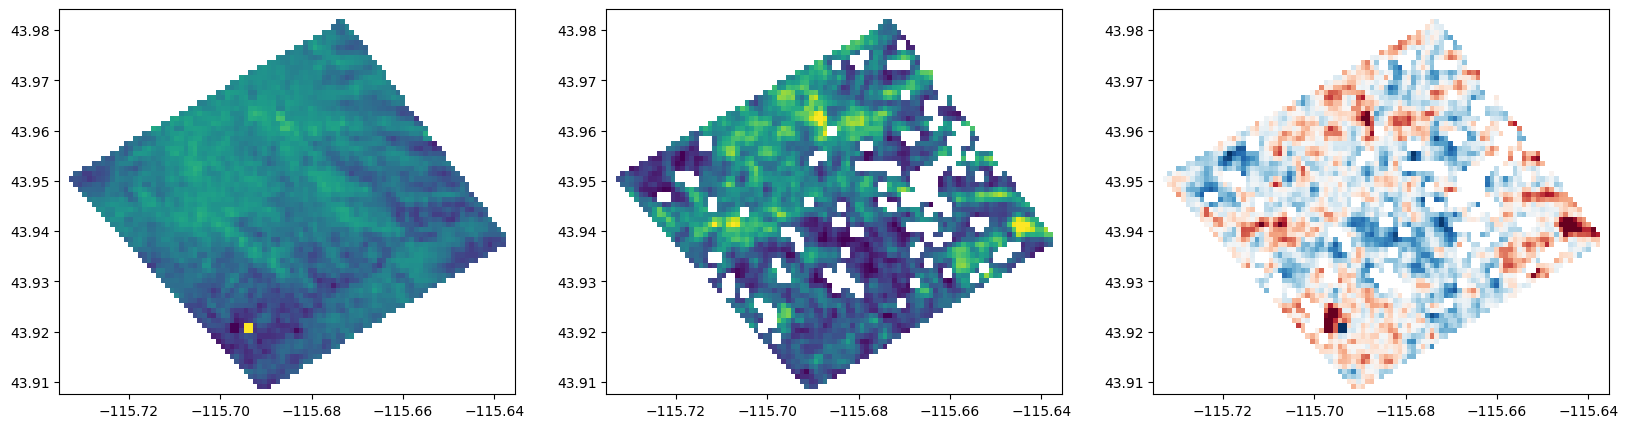

In [63]:
fig, ax = plt.subplots(1,3,figsize = (20,5))

ax[0].pcolormesh(closest_ds.x, closest_ds.y, lidar, vmin = 0, vmax = 4)
ax[1].pcolormesh(closest_ds.x, closest_ds.y, s1, vmin = 0, vmax = 4)
ax[2].pcolormesh(closest_ds.x, closest_ds.y, lidar - s1, vmin = -2, vmax = 2, cmap = 'RdBu')

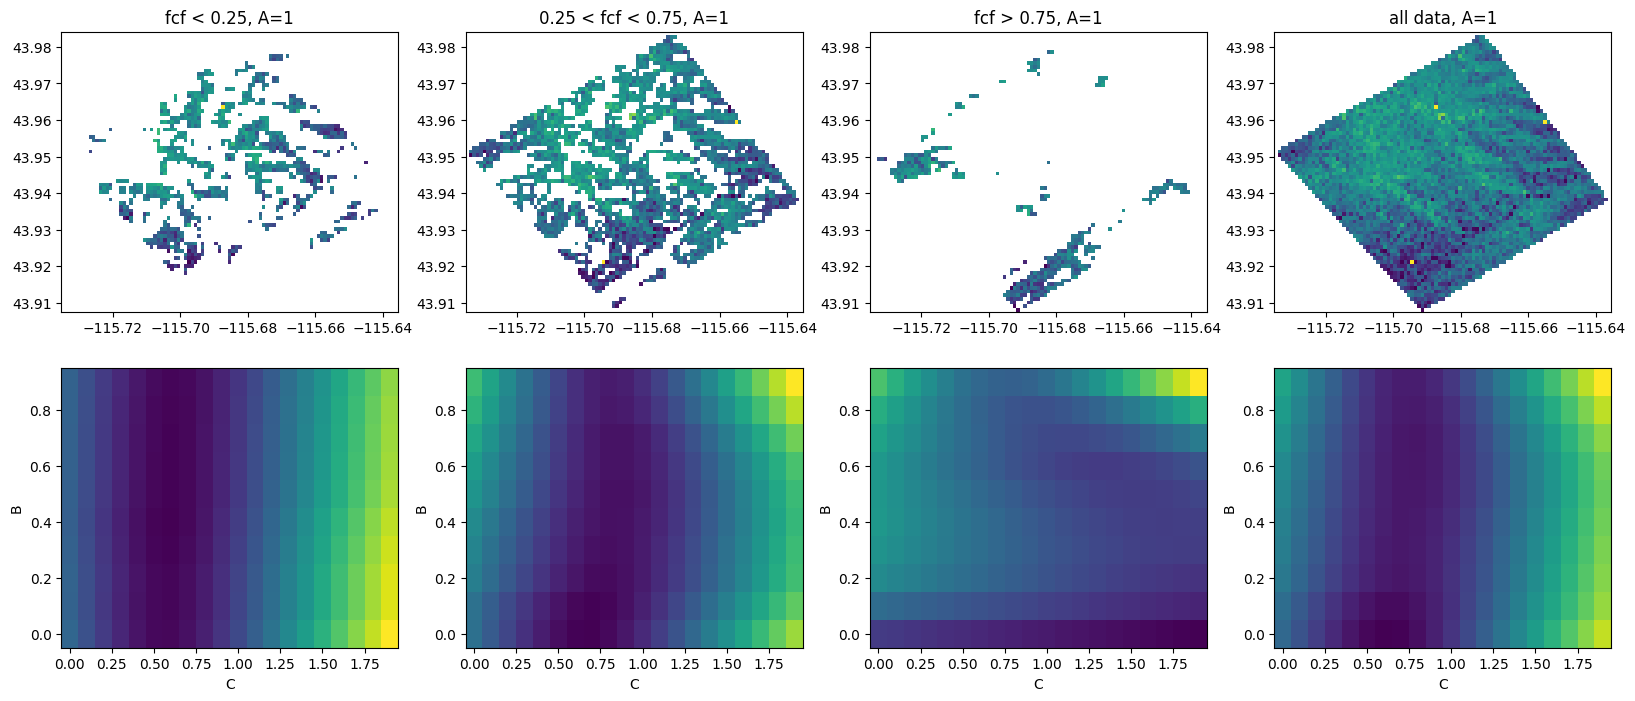

In [5]:
fig, ax = plt.subplots(2,4, figsize = (20,8))
titles = ['fcf < 0.25, A=1', '0.25 < fcf < 0.75, A=1', 'fcf > 0.75, A=1', 'all data, A=1']

for i in range(len(all_rmse_datasets)):
    d1 = all_datasets[i]
    ax[0,i].pcolormesh(d1.x, d1.y, d1['lidar-sd'], vmin = 0, vmax = 4)
    ax[0,i].set_title(titles[i])
    
    d = all_rmse_datasets[i].sel(A=1)
    ax[1,i].pcolormesh(d.C, d.B, d)
    ax[1,i].set_xlabel('C')
    ax[1,i].set_ylabel('B')

